#INTRODUCTION

In this notebook , we will be removing the gender bias present in the [bollywood plot dataset](https://raw.githubusercontent.com/BollywoodData/Bollywood-Data/master/wikipedia-data/coref_plot.csv) . The notebook uses the techniques and methodology used in the paper : [Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings](https://papers.nips.cc/paper/2016/file/a486cd07e4ac3d270571622f4f316ec5-Paper.pdf) . Also, this [blog](https://towardsdatascience.com/tackling-gender-bias-in-word-embeddings-c965f4076a10) gives a clear brief of the paper mentioned above .

We import the necessary libraries .

In [1]:
import pandas as pd
import numpy as np
import string
import re
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import gensim
import nltk
from gensim import corpora, models, similarities
from nltk import word_tokenize

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Read the data from [Bollywood-Data](https://github.com/BollywoodData/Bollywood-Data) .

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/BollywoodData/Bollywood-Data/master/wikipedia-data/coref_plot.csv')

In [5]:
data.shape

(34728, 3)

In [6]:
data.head()

,Unnamed: 0,Movie Name,Coref Plot
0,0,Aan Milo Sajna,Widowed and ailing Savitri Choudhury lives a ...
1,1,Aan Milo Sajna,Savitri knows that Anil is only waiting for S...
2,2,Aan Milo Sajna,The Diwan convinces Anil to mend Anil ways g...
3,3,Aan Milo Sajna,Shortly thereafter Anil does appear to have m...
4,4,Aan Milo Sajna,Deepali moves in the mansion looks after Sav...


We only need the "Coref Plot" column .

In [7]:
df = data['Coref Plot']

In [8]:
def no_uniquewords(df):
  unique_words =[]
  for count,line in enumerate (df):
    line = line.strip().split()
    for word in line:
      if word not in unique_words:
        unique_words.append(word)
  print("The number of unique words are : ",len(unique_words))

We calculate the number of unique words because later on, we will set the hyperparameter min_count of the gensim model as 1 . Therefore, the length of the vocabulary of the model should be equal to the number of unique words .

In [9]:
words = []
for count,line in enumerate (df):
  line = line.strip().split()
  for word in line:
    words.append(word)
len(words)

646995

#Preprocessing / Cleaning the data

We clean the data by making all the strings into lowercase and removing punctuations .

In [10]:
df[:2]

0     Widowed and ailing Savitri Choudhury lives a ...
1     Savitri knows that Anil is only waiting for S...
Name: Coref Plot, dtype: object

In [11]:
l_sentence = [sentence.lower() for sentence in df]
l_sentence[:2]

[' widowed and ailing savitri choudhury lives a wealthy lifestyle along with savitri son  anil  in a palatial mansion in india',
 ' savitri knows that anil is only waiting for savitri to die so that anil can inherit the wealth and refuses to give anil any money']

Great, we've made all the words into lowercase .

In [12]:
table = str.maketrans('', '', string.punctuation)
stripped = [a.translate(table) for a in l_sentence]
stripped[:2]

[' widowed and ailing savitri choudhury lives a wealthy lifestyle along with savitri son  anil  in a palatial mansion in india',
 ' savitri knows that anil is only waiting for savitri to die so that anil can inherit the wealth and refuses to give anil any money']

In [13]:
no_uniquewords(df)

The number of unique words are :  26743


In [14]:
no_uniquewords(stripped)

The number of unique words are :  24447


The number of unique words has decreased because of making all the words into lowercase .

Now we will tokenize the sentence . Which generally means to split into seperate words . 

In [15]:
tok_corpus = [nltk.word_tokenize(sent) for sent in stripped]

In [16]:
tok_corpus[:1]

[['widowed',
  'and',
  'ailing',
  'savitri',
  'choudhury',
  'lives',
  'a',
  'wealthy',
  'lifestyle',
  'along',
  'with',
  'savitri',
  'son',
  'anil',
  'in',
  'a',
  'palatial',
  'mansion',
  'in',
  'india']]

The above individual tokens belong to the first line of the plot dataset .

Now we will take all the respective adjectives and verbs predominately associated with male and female .

In [17]:
female_verb = pd.read_csv('https://raw.githubusercontent.com/BollywoodData/Bollywood-Data/master/wikipedia-data/female_verb.csv',
                         error_bad_lines=False, header = None)
female_verb.shape

b'Skipping line 4: expected 2 fields, saw 3\nSkipping line 5: expected 2 fields, saw 3\nSkipping line 9: expected 2 fields, saw 8\nSkipping line 11: expected 2 fields, saw 3\nSkipping line 19: expected 2 fields, saw 5\nSkipping line 21: expected 2 fields, saw 3\nSkipping line 23: expected 2 fields, saw 4\nSkipping line 26: expected 2 fields, saw 4\nSkipping line 40: expected 2 fields, saw 7\nSkipping line 41: expected 2 fields, saw 3\nSkipping line 43: expected 2 fields, saw 6\nSkipping line 44: expected 2 fields, saw 6\nSkipping line 46: expected 2 fields, saw 3\nSkipping line 48: expected 2 fields, saw 6\nSkipping line 49: expected 2 fields, saw 4\nSkipping line 54: expected 2 fields, saw 4\nSkipping line 60: expected 2 fields, saw 4\nSkipping line 61: expected 2 fields, saw 6\nSkipping line 65: expected 2 fields, saw 4\nSkipping line 76: expected 2 fields, saw 3\nSkipping line 79: expected 2 fields, saw 3\nSkipping line 81: expected 2 fields, saw 4\nSkipping line 82: expected 2 fiel

(3519, 2)

In [18]:
female_adj = pd.read_csv('https://raw.githubusercontent.com/BollywoodData/Bollywood-Data/master/wikipedia-data/female_adjectives.csv',
                         error_bad_lines=False, header = None)
female_adj.shape

b'Skipping line 32: expected 2 fields, saw 3\nSkipping line 38: expected 2 fields, saw 3\nSkipping line 140: expected 2 fields, saw 4\nSkipping line 163: expected 2 fields, saw 3\nSkipping line 173: expected 2 fields, saw 3\nSkipping line 183: expected 2 fields, saw 3\nSkipping line 189: expected 2 fields, saw 3\nSkipping line 209: expected 2 fields, saw 3\nSkipping line 215: expected 2 fields, saw 3\nSkipping line 222: expected 2 fields, saw 3\nSkipping line 286: expected 2 fields, saw 4\nSkipping line 298: expected 2 fields, saw 3\nSkipping line 310: expected 2 fields, saw 3\nSkipping line 311: expected 2 fields, saw 3\nSkipping line 345: expected 2 fields, saw 3\nSkipping line 363: expected 2 fields, saw 4\nSkipping line 455: expected 2 fields, saw 3\nSkipping line 478: expected 2 fields, saw 3\nSkipping line 488: expected 2 fields, saw 3\nSkipping line 494: expected 2 fields, saw 3\nSkipping line 499: expected 2 fields, saw 3\nSkipping line 501: expected 2 fields, saw 3\nSkipping l

(4859, 2)

In [19]:
count = 0
female_words =[]
for i in female_adj[1]:
  if i != '[]':
    i = i.lower()
    i = i.strip(']')
    i = i.strip('[')
    if i not in female_words:
      female_words.append(i)
      count =count +1
print(count)

372


In [20]:
for i in female_verb[1]:
  if i != '[]':
    i = i.strip(']')
    i = i.strip('[')
    if i not in female_words:
      female_words.append(i)
      count =count +1
print(count)

718


In [21]:
len(female_words)

718

In [22]:
male_adj = pd.read_csv('https://raw.githubusercontent.com/BollywoodData/Bollywood-Data/master/wikipedia-data/male_adjectives.csv',
                         error_bad_lines=False, header = None)
male_adj.shape

b'Skipping line 6: expected 2 fields, saw 3\nSkipping line 44: expected 2 fields, saw 3\nSkipping line 60: expected 2 fields, saw 3\nSkipping line 61: expected 2 fields, saw 3\nSkipping line 107: expected 2 fields, saw 3\nSkipping line 112: expected 2 fields, saw 3\nSkipping line 123: expected 2 fields, saw 3\nSkipping line 151: expected 2 fields, saw 3\nSkipping line 211: expected 2 fields, saw 3\nSkipping line 219: expected 2 fields, saw 3\nSkipping line 256: expected 2 fields, saw 4\nSkipping line 342: expected 2 fields, saw 3\nSkipping line 360: expected 2 fields, saw 3\nSkipping line 382: expected 2 fields, saw 3\nSkipping line 428: expected 2 fields, saw 3\nSkipping line 455: expected 2 fields, saw 4\nSkipping line 490: expected 2 fields, saw 3\nSkipping line 520: expected 2 fields, saw 3\nSkipping line 587: expected 2 fields, saw 3\nSkipping line 588: expected 2 fields, saw 3\nSkipping line 602: expected 2 fields, saw 3\nSkipping line 604: expected 2 fields, saw 4\nSkipping line

(9107, 2)

In [23]:
male_verb = pd.read_csv('https://raw.githubusercontent.com/BollywoodData/Bollywood-Data/master/wikipedia-data/male_verb.csv',
                         error_bad_lines=False, header = None)
male_verb.shape

b'Skipping line 7: expected 2 fields, saw 4\nSkipping line 13: expected 2 fields, saw 5\nSkipping line 15: expected 2 fields, saw 4\nSkipping line 21: expected 2 fields, saw 4\nSkipping line 22: expected 2 fields, saw 3\nSkipping line 25: expected 2 fields, saw 3\nSkipping line 26: expected 2 fields, saw 3\nSkipping line 28: expected 2 fields, saw 3\nSkipping line 31: expected 2 fields, saw 4\nSkipping line 33: expected 2 fields, saw 6\nSkipping line 34: expected 2 fields, saw 3\nSkipping line 36: expected 2 fields, saw 3\nSkipping line 41: expected 2 fields, saw 3\nSkipping line 46: expected 2 fields, saw 3\nSkipping line 49: expected 2 fields, saw 5\nSkipping line 51: expected 2 fields, saw 3\nSkipping line 54: expected 2 fields, saw 3\nSkipping line 56: expected 2 fields, saw 3\nSkipping line 64: expected 2 fields, saw 3\nSkipping line 66: expected 2 fields, saw 3\nSkipping line 67: expected 2 fields, saw 3\nSkipping line 68: expected 2 fields, saw 3\nSkipping line 70: expected 2 fi

(6317, 2)

In [24]:
count = 0
male_words =[]
for i in male_adj[1]:
  if i != '[]':
    i = i.lower()
    i = i.strip(']')
    i = i.strip('[')
    if i not in male_words:
      male_words.append(i)
      count =count +1
print(count)

525


In [25]:
for i in male_verb[1]:
  if i != '[]':
    i = i.strip(']')
    i = i.strip('[')
    if i not in male_words:
      male_words.append(i)
      count =count +1
print(count)

1038


In [26]:
len(male_words)

1038

# word2vec

Now, we use the [models.word2vec](https://radimrehurek.com/gensim/models/word2vec.html) from [gensim](https://radimrehurek.com/gensim/intro.html)  to get the vector representation of the above words/tokens .

In [27]:
model = gensim.models.Word2Vec(tok_corpus, min_count = 1, size=32)

In [28]:
vocabulary = model.wv.vocab

The above code returns a dictionary of words and their respective vectors . The length of the dictionary should be equal to the number of unique words after data preprocessing .

In [29]:
len(vocabulary)

24447

In [30]:
vocab_list = list()
for i in vocabulary.keys():
    vocab_list.append(i)
len(vocab_list)

24447

In [31]:
common_female_list = []
for value in female_words :
  if value in vocab_list:
    common_female_list.append(value)
  else:
    continue
len(common_female_list)

690

In [32]:
common_male_list = []
for value in male_words :
  if value in vocab_list:
    common_male_list.append(value)
  else:
    continue
len(common_male_list)

1004

In [33]:
total_gender_based_words = []
total_gender_based_words = common_female_list + common_male_list
len(total_gender_based_words)

1694

In [34]:
definitional_pairs = [["woman", "man"], ["girl", "boy"], ["she", "he"], 
 ["mother", "father"], ["daughter", "son"], ["gal", "guy"], 
 ["female", "male"], ["her", "his"], ["herself", "himself"]]

In [35]:
for i in definitional_pairs:
  for a in i:
    if a in total_gender_based_words:
      print(a)

girl
female


In [36]:
common_female_list.remove('female')
common_female_list.remove('girl')

In [37]:
total_gender_based_words = []
total_gender_based_words = common_female_list + common_male_list
len(total_gender_based_words)

1692

In [38]:
equalize_pairs = [["monastery", "convent"], ["spokesman", "spokeswoman"], ["Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"], 
 ["councilman", "councilwoman"], ["grandpa", "grandma"], ["grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"], 
 ["testosterone", "estrogen"], ["uncle", "aunt"], ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"], ["He", "She"], 
 ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], ["brothers", "sisters"], ["businessman", "businesswoman"], ["chairman", "chairwoman"], 
 ["colt", "filly"], ["congressman", "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"], ["ex_girlfriend", "ex_boyfriend"], 
 ["father", "mother"], ["fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"], ["fraternity", "sorority"], ["gelding", "mare"], 
 ["gentleman", "lady"], ["gentlemen", "ladies"], ["grandfather", "grandmother"], ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"],
 ["his", "her"], ["king", "queen"], ["kings", "queens"], ["male", "female"], ["males", "females"], ["man", "woman"], ["men", "women"], ["nephew", "niece"], 
 ["prince", "princess"], ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]]

In [39]:
for i in equalize_pairs:
  for a in i:
    if a in total_gender_based_words:
      print(a)

brother
sister
niece
princess
schoolgirl


In [40]:
common_female_list.remove('sister')
common_male_list.remove('sister')
common_female_list.remove('niece')
common_female_list.remove('princess')
common_female_list.remove('schoolgirl')
common_female_list.remove('brother')

In [41]:
total_gender_based_words = []
total_gender_based_words = common_female_list + common_male_list
len(total_gender_based_words)

1686

We have removed gender-specific words from the adjective/verb list .

In [42]:
x_pair = []
for pair in equalize_pairs:
  if pair[0] in vocab_list and pair[1] in vocab_list:
    x_pair.append(pair)

In [43]:
len(equalize_pairs)

52

In [44]:
len(x_pair)

31

In [45]:
for pair in definitional_pairs:
  if pair[0] in x_pair and pair[1] in x_pair: 
    print(pair)

In [46]:
gender_specific_pair = definitional_pairs + x_pair

In [47]:
len(gender_specific_pair)

40

# Cosine similarity

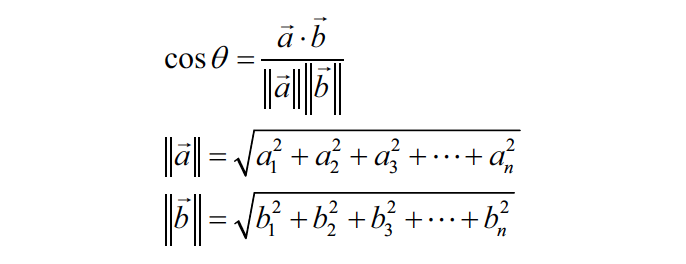
[source](https://www.google.com/url?sa=i&url=https%3A%2F%2Fmedium.com%2Facing-ai%2Fwhat-is-cosine-similarity-matrix-f0819e674ad1&psig=AOvVaw0elYRXcR5OY-WU8125VnYO&ust=1630996233751000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCOia3svc6fICFQAAAAAdAAAAABAJ)

Using the above formula we can compute the cosine similarity .

In [48]:
def cos_similarity(a, b):
    
    distance = 0.0
    
    dot = np.dot(a, b)
    norm_a = np.sqrt(np.sum(a**2))
    norm_b = np.sqrt(np.sum(b**2))
    cosine_similarity = dot / np.dot(norm_a, norm_b)
    return cosine_similarity

In [49]:
cos_similarity(model['man'], model['nurse'])

0.6534883

In [50]:
cos_similarity(model['woman'], model['nurse'])

0.67397875

In [51]:
cos_similarity(model['man'], model['police'])

0.35268646

In [52]:
cos_similarity(model['woman'], model['police'])

0.23778215

It is clear to see that there are some bias between various professions .

#DE-BIASING

We get the gender subspace by taking the difference of some pre-known sets that define the concept of gender itself.

In [53]:
g = model['she'] - model['he']
print(g)

[ 0.3338003  -0.4559958   0.6122649   0.06170356 -0.5258467  -0.43469048
  0.23330486  0.46621406 -0.09430885  0.32342157  0.26224226  0.06922233
 -0.29831314 -0.4014731   1.3185687  -0.2849674   0.57626516 -0.75719774
  0.4448303  -1.1423762  -0.05292112 -0.49498105  0.01147079 -0.42017174
 -0.42658055  0.12266612 -0.8267737  -0.31476825 -0.08094317 -0.02058506
 -0.15319315 -0.05468857]


In [54]:
cos_similarity(model['she'],model['he'])

0.93361527

In [55]:
print ('List of names and their similarities with their respective vector:')

character_name_list = [ 'naina', 'sudhir', 'chanda', 'vikram', 'seema', 'naresh']

for w in character_name_list:
    print (w, cos_similarity(model[w], g))

List of names and their similarities with their respective vector:
naina -0.06333826
sudhir -0.26586112
chanda -0.09942507
vikram -0.23911087
seema -0.07578385
naresh -0.06255474


In the above code we've taken pairs of characters(female and male ) from the same plot . We can also observe that the female charachter of the same plot seems to have a value which is greater than or positive to that of the male charchter .

In [56]:
model.most_similar('doctor')

[('letter', 0.9513421654701233),
 ('heart', 0.9467182159423828),
 ('body', 0.9373484253883362),
 ('witch', 0.9341596364974976),
 ('baby', 0.928030252456665),
 ('patient', 0.926253616809845),
 ('latter', 0.925542414188385),
 ('shock', 0.921873927116394),
 ('judge', 0.9206643104553223),
 ('investor', 0.9190220832824707)]

In [57]:
professions_and_nouns = ['police','nurse','peasant','postman','boss','professor','assistant','advocate','farmer','merchant','smuggler','director','producer',
                         'journalist','editor','thug','mechanic','dancer','industrialist','tycoon','artist','widower','drunkard','engineer',
                         'soldier','contractor','retired','inspector','commissioner','superintendent','security','don','writer','alcoholic',
                         'software','employee','lawyer','psychiatrist','patient','photographer','teenager','headmaster','student','model',
                         'graduate','teacher','scientist','researcher','homemaker','bureaucrat','politician','minister','guards','doctor']

We take some common professions and nouns related to profession . In order to neutralize such that they remain equidistant from equality pairs like “he-she". Technically, what happens is that the projection of the embedding on the bias direction is subtracted from the vector.


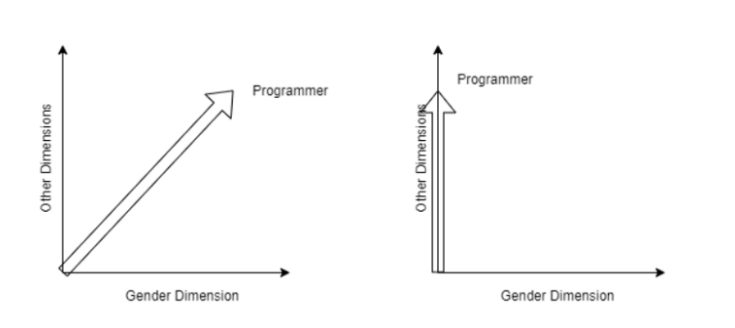

[Source](https://towardsdatascience.com/tackling-gender-bias-in-word-embeddings-c965f4076a10)

$ e^{bias\_component} = \frac{e \cdot g}{||g||_2^2} * g\tag{1} $

$ e^{debiased} = e - e^{bias\_component}\tag{2} $

We make a new dictionary(debiased_vocab) to store all the corrected vector values .

In [58]:
debiased_vocab = {}

In [59]:
def neutralise(word, g, model, debiased_vocab):
    
    #model.wv.syn0norm = None
    #model.wv.init_sims()
    
    e = model[word]
    
    e_biascomponent = (np.dot(e,g)/np.linalg.norm(g, ord=2)**2)*g
 
    e_debiased = e - e_biascomponent

    debiased_vocab[word] = e_debiased
    
    return e_debiased, debiased_vocab


In [60]:
for a in professions_and_nouns:
  print("cosine similarity between " + a + " and g, before neutralising: ", cos_similarity(model[a], g))

  e_debiased, debiased_vocab = neutralise( a , g, model, debiased_vocab)
  #model.wv.syn0norm[model.wv.vocab[a].index] = e_debiased
  print("cosine similarity between " + a + " and g, after neutralising: ", cos_similarity(e_debiased, g))

cosine similarity between police and g, before neutralising:  -0.19889942
cosine similarity between police and g, after neutralising:  8.330943e-09
cosine similarity between nurse and g, before neutralising:  -0.17551173
cosine similarity between nurse and g, after neutralising:  6.675964e-09
cosine similarity between peasant and g, before neutralising:  -0.13841528
cosine similarity between peasant and g, after neutralising:  -2.223875e-08
cosine similarity between postman and g, before neutralising:  -0.14346166
cosine similarity between postman and g, after neutralising:  2.3539593e-08
cosine similarity between boss and g, before neutralising:  -0.24453214
cosine similarity between boss and g, after neutralising:  5.78999e-08
cosine similarity between professor and g, before neutralising:  -0.059681218
cosine similarity between professor and g, after neutralising:  -8.693948e-09
cosine similarity between assistant and g, before neutralising:  -0.13124327
cosine similarity between as

To understand syn0norm and its use in the above code, check [this](https://stackoverflow.com/questions/46647945/how-to-manually-change-the-vector-dimensions-of-a-word-in-gensim-word2vec) out .

Now that we've neutralized some of the general professions(nouns) . Let us neutralize the adjectives and verbs .

In [61]:
for count in total_gender_based_words:
  e_debiased,debiased_vocab = neutralise(count, g, model, debiased_vocab)

In [62]:
len(debiased_vocab)

1334

Now all the verbs and adjectives are neutralised .


# Equalising 

The gender specific terms are equalised or averaged out to have the same vector length . For example, the term doctor should be equidistant to both guy-girl and man-woman.

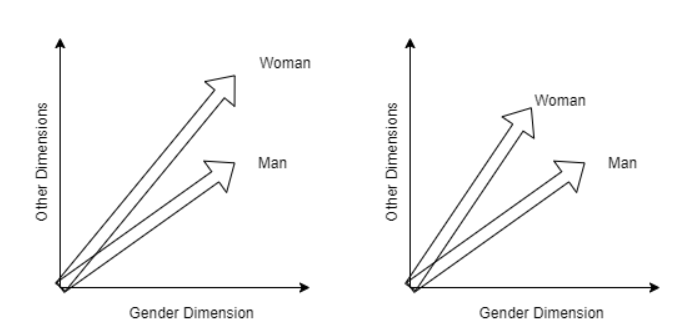

[Source](https://towardsdatascience.com/tackling-gender-bias-in-word-embeddings-c965f4076a10)

$ \mu = \frac{e_{w1} + e_{w2}}{2}\tag{3} $

$\mu_{B} = \frac {\mu \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{4
}$

$ \mu_{\perp} = \mu - \mu_{B} \tag{5} $

$ e_{w1B} = \frac {e_{w1} \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{6} $

$ e_{w2B} = \frac {e_{w2} \cdot \text{bias_axis}}{||\text{bias_axis}||_2^2} *\text{bias_axis}
\tag{7} $

$ e_{w1B}^{corrected} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{e_{\text{w1B}} - \mu_B} {|(e_{w1} - \mu_{\perp}) - \mu_B)|} \tag{8} $

$ e_{w2B}^{corrected} = \sqrt{ |{1 - ||\mu_{\perp} ||^2_2} |} * \frac{e_{\text{w2B}} - \mu_B} {|(e_{w2} - \mu_{\perp}) - \mu_B)|} \tag{9} $

$e_1 = e_{w1B}^{corrected} + \mu_{\perp} \tag{10}$

$e_2 = e_{w2B}^{corrected} + \mu_{\perp} \tag{11}$

In [63]:
def equalise(pair, g , model, debiased_vocab):
    
    

    w1, w2 = pair[0], pair[1] 
    e_w1, e_w2 = model[pair[0]], model[pair[1]]
    
    mu = (e_w1+e_w2)/2

    mu_B = (np.dot(mu,g)*g/np.linalg.norm(g)**2)
    mu_orth = (mu - mu_B)

    e_w1B = (np.dot(e_w1,g)*g/np.linalg.norm(g)**2)
    e_w2B = (np.dot(e_w2,g)*g/np.linalg.norm(g)**2)
        
    corrected_e_w1B = np.sqrt(abs(1-np.linalg.norm(mu_orth)**2))*(e_w1B - mu_B)/np.sum(e_w1 - mu_orth - mu_B)
    corrected_e_w2B = np.sqrt(abs(1-np.linalg.norm(mu_orth)**2))*(e_w2B - mu_B)/np.sum(e_w2 - mu_orth - mu_B)

    e1 = (corrected_e_w1B + mu_orth)
    e2 = (corrected_e_w2B + mu_orth)

    debiased_vocab[w1] = e1
    debiased_vocab[w2] = e2
                                                                
    
    return e1, e2, debiased_vocab

In [64]:
gender_specific_pair

[['woman', 'man'],
 ['girl', 'boy'],
 ['she', 'he'],
 ['mother', 'father'],
 ['daughter', 'son'],
 ['gal', 'guy'],
 ['female', 'male'],
 ['her', 'his'],
 ['herself', 'himself'],
 ['monastery', 'convent'],
 ['grandpa', 'grandma'],
 ['grandsons', 'granddaughters'],
 ['uncle', 'aunt'],
 ['wives', 'husbands'],
 ['boy', 'girl'],
 ['boys', 'girls'],
 ['brother', 'sister'],
 ['brothers', 'sisters'],
 ['businessman', 'businesswoman'],
 ['dad', 'mom'],
 ['father', 'mother'],
 ['fatherhood', 'motherhood'],
 ['fathers', 'mothers'],
 ['gentleman', 'lady'],
 ['gentlemen', 'ladies'],
 ['grandfather', 'grandmother'],
 ['grandson', 'granddaughter'],
 ['he', 'she'],
 ['himself', 'herself'],
 ['his', 'her'],
 ['king', 'queen'],
 ['kings', 'queens'],
 ['male', 'female'],
 ['males', 'females'],
 ['man', 'woman'],
 ['men', 'women'],
 ['nephew', 'niece'],
 ['prince', 'princess'],
 ['son', 'daughter'],
 ['sons', 'daughters']]

The above pairs of words are gender-specific .

In [65]:
for pair in gender_specific_pair :
  print("cosine similarities before equalizing:")
  print("cosine similarity of",pair[0], cos_similarity(model[pair[0]],g))
  print("cosine similarity of",pair[1], cos_similarity(model[pair[1]],g))

  e1, e2, debiased_vocab = equalise(pair, g, model, debiased_vocab)
  print("cosine similarities after equalizing:")
  print("cosine similarity of",pair[0], cos_similarity(e1 ,g))
  print("cosine similarity of",pair[1], cos_similarity(e2 ,g))
  print('\n')


cosine similarities before equalizing:
cosine similarity of woman 0.058637153
cosine similarity of man -0.026633695
cosine similarities after equalizing:
cosine similarity of woman 0.85733014
cosine similarity of man 0.85732937


cosine similarities before equalizing:
cosine similarity of girl 0.05338845
cosine similarity of boy -0.06867759
cosine similarities after equalizing:
cosine similarity of girl -0.55211115
cosine similarity of boy -0.5521115


cosine similarities before equalizing:
cosine similarity of she -0.29990187
cosine similarity of he -0.6217786
cosine similarities after equalizing:
cosine similarity of she -0.7471634
cosine similarity of he -0.7471635


cosine similarities before equalizing:
cosine similarity of mother -0.26931575
cosine similarity of father -0.33802631
cosine similarities after equalizing:
cosine similarity of mother -0.2128976
cosine similarity of father -0.21289773


cosine similarities before equalizing:
cosine similarity of daughter -0.16050352
co

In [66]:
len(debiased_vocab)

1398

In [67]:
cos_similarity(debiased_vocab['woman'], debiased_vocab['police'])

0.16035226

In [68]:
cos_similarity(debiased_vocab['man'], debiased_vocab['police'])  

0.16035278

In [69]:
cos_similarity(debiased_vocab['gal'], debiased_vocab['nurse'])

0.9225699

In [70]:
cos_similarity(debiased_vocab['guy'], debiased_vocab['nurse'])

0.92256975

In [71]:
cos_similarity(debiased_vocab['herself'], debiased_vocab['pretty'])

0.37438145

In [72]:
cos_similarity(debiased_vocab['himself'], debiased_vocab['pretty'])

0.37438014

Great, we have removed bias from the plot. 

# Conclusion

We took the bollywood dataset, cleaned and tokenized it. Then, applied word2vec on the corpus/tokens . Seperated the gender-specific words , gender stereotyped professions and the adjectives or verbs which were predominately used in association with male or female . We neutralized the gender stereotyped professions and the adjectives / verbs . And equalized the gender-specific terms. Finally, we observed the cosine similarity between a couple of gender-stereotyped professions and gender-specific words to be similar. Hence , we've succeeded in removing some bias .